In [1]:
# Import all required modules
import os
import zipfile
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from skimage.feature import hog
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Constants
TRAIN_ZIP = '/kaggle/input/dogs-vs-cats/train.zip'
TEST_ZIP = '/kaggle/input/dogs-vs-cats/test1.zip'
IMG_SIZE = (128, 128)
SAMPLE_SIZE = 20000
TEST_SIZE = 0.2
VISUALIZATION_SAMPLES = 8

# **Extract sample images for visualization**

In [3]:
def extract_sample_images(zip_path, num_samples=8):
    samples = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        image_files = [f for f in file_list if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # Get balanced samples of cats and dogs
        cats = [f for f in image_files if 'cat' in os.path.basename(f).lower()][:num_samples//2]
        dogs = [f for f in image_files if 'dog' in os.path.basename(f).lower()][:num_samples//2]
        
        for image_file in cats + dogs:
            with zip_ref.open(image_file) as file:
                img_array = np.frombuffer(file.read(), dtype=np.uint8)
                img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    samples.append((img, 'cat' if 'cat' in image_file.lower() else 'dog'))
    return samples

# **Display sample images with labels**

In [4]:
def visualize_sample_images(samples):
    plt.figure(figsize=(12, 6))
    for i, (img, label) in enumerate(samples):
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle("Sample Training Images", fontsize=16)
    plt.tight_layout()
    plt.show()

# **Load and preprocess images**

In [5]:
def load_data(zip_path, sample_size=None):
    X = []
    y = []
    class_files = {'cat': [], 'dog': []}
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        for image_file in file_list:
            if not image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            filename = os.path.basename(image_file).lower()
            if 'dog' in filename:
                class_files['dog'].append(image_file)
            elif 'cat' in filename:
                class_files['cat'].append(image_file)

    min_samples = min(len(class_files['cat']), len(class_files['dog']))
    if sample_size:
        min_samples = min(min_samples, sample_size // 2)
    
    print(f"Using {min_samples} samples per class")
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for class_name, files in class_files.items():
            for image_file in tqdm(files[:min_samples], desc=f"Processing {class_name}"):
                with zip_ref.open(image_file) as file:
                    img_array = np.frombuffer(file.read(), dtype=np.uint8)
                    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
                    
                    if img is None:
                        continue
                        
                    img = cv2.resize(img, IMG_SIZE)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    
                    # Extract HOG features
                    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                    features = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                                  cells_per_block=(1, 1), visualize=False)
                    
                    X.append(features)
                    y.append(0 if class_name == 'cat' else 1)
    
    return np.array(X), np.array(y)

# **Visualize model predictions on sample images**

In [6]:
def visualize_predictions(model, pca, test_images):
    plt.figure(figsize=(15, 8))
    gs = GridSpec(2, 4)
    
    for i, (img, true_label) in enumerate(test_images):
        # Preprocess the same way as training data
        img_processed = cv2.resize(img, IMG_SIZE)
        gray = cv2.cvtColor(img_processed, cv2.COLOR_RGB2GRAY)
        features = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1), visualize=False)
        
        # Predict
        features_pca = pca.transform([features])
        pred = model.predict(features_pca)[0]
        proba = model.predict_proba(features_pca)[0]
        
        # Create subplot
        ax = plt.subplot(gs[i])
        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPred: {'cat' if pred == 0 else 'dog'}\n"
                    f"Confidence: {max(proba)*100:.1f}%", fontsize=10)
        ax.axis('off')
        
        # Add color border based on correctness
        border_color = 'green' if ('cat' if pred == 0 else 'dog') == true_label else 'red'
        for spine in ax.spines.values():
            spine.set_color(border_color)
            spine.set_linewidth(3)
    
    plt.suptitle("Model Predictions on Sample Images\n(Green=Correct, Red=Incorrect)", fontsize=14)
    plt.tight_layout()
    plt.show()

# **Main execution**

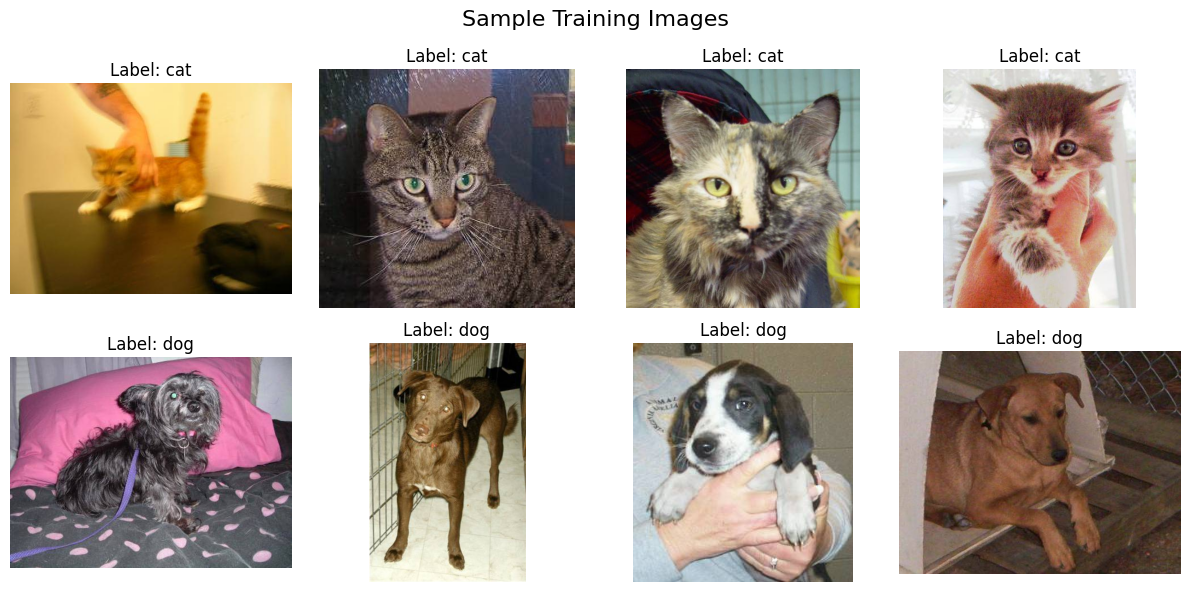

Using 10000 samples per class


Processing dog: 100%|██████████| 10000/10000 [00:39<00:00, 253.51it/s]



Classification Report:
              precision    recall  f1-score   support

         cat       0.75      0.75      0.75      2019
         dog       0.75      0.74      0.74      1981

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



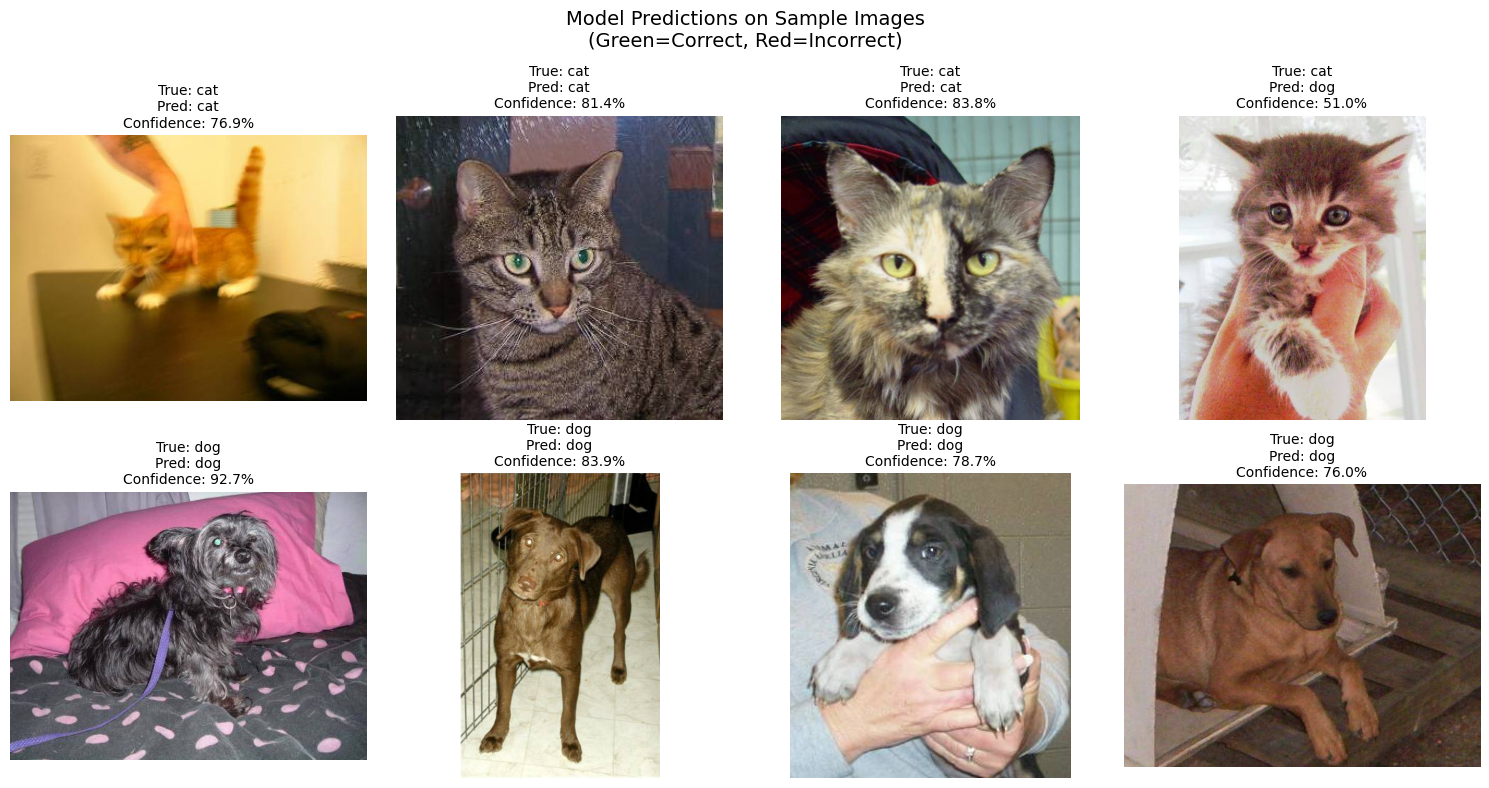

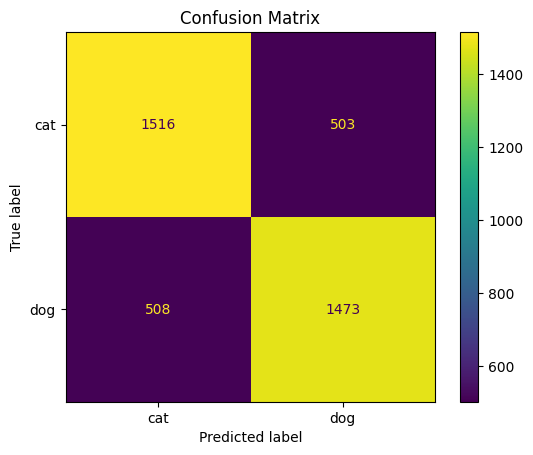

In [7]:
if __name__ == "__main__":
    # Extract and visualize sample images
    sample_images = extract_sample_images(TRAIN_ZIP, VISUALIZATION_SAMPLES)
    visualize_sample_images(sample_images)
    
    # Load and process data
    X, y = load_data(TRAIN_ZIP, SAMPLE_SIZE)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
    
    # Dimensionality reduction
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Train SVM
    svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
    svm.fit(X_train_pca, y_train)
    
    # Evaluate
    y_pred = svm.predict(X_test_pca)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['cat', 'dog']))
    
    # Visualize predictions
    test_samples = extract_sample_images(TRAIN_ZIP, VISUALIZATION_SAMPLES)  # Using training samples for demo
    visualize_predictions(svm, pca, test_samples)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cat', 'dog'])
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()